In [1]:
from IPython.display import SVG, Image
from rdkit import Chem
from rdkit.Chem import rdDepictor,Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import re
from EFGs import mol2frag

In [2]:
def prettymol(smiles, asMol=False, label=None, path='', imgsize=(300, 200), highlights=None):
    '''
    highlights is a dictionary, which may contains:
    highlightAtoms: list
    highlightBonds: list
    highlightAtomRadii: dict[int]=float, atom index (int), radius (float)
    highlightAtomColors: dict[int]=tuple, index (int), color (tuple, length=3)
    highlightBondColors: dict[int]=tuple,index (int), color (tuple, length=3)
    '''
    if asMol:
        mol = smiles.__copy__()
    else:
        mol = Chem.MolFromSmiles(smiles)
    try:
        mol = rdMolDraw2D.PrepareMolForDrawing(mol)
        if '.png' in path:
            drawer = rdMolDraw2D.MolDraw2DCairo(*imgsize)
        else:
            drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
        opts = drawer.drawOptions()
        if label == 'map':
            for i in range(mol.GetNumAtoms()):
                opts.atomLabels[i] = mol.GetAtomWithIdx(
                    i).GetSymbol()+str(mol.GetAtomWithIdx(i).GetAtomMapNum())
        if label == 'idx':
            for i in range(mol.GetNumAtoms()):
                opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)
        if not highlights:
            drawer.DrawMolecule(mol)
        else:
            drawer.DrawMolecule(mol, **highlights)
        drawer.FinishDrawing()
        if '.png' in path:
            drawer.WriteDrawingText(path)
            display(Image(path))
        else:
            svg = drawer.GetDrawingText()
            display(SVG(svg.replace('svg:','')))
            if '.svg' in path:
                with open(path, 'w') as wf:
                    print(svg, file=wf)
        return drawer
    except Exception as e:
        print("Check your molecule!!!",e)
        return

Input SMILES:Cc1cc(O)c2c(c1)C(=O)c1cccc(O)c1C2=O


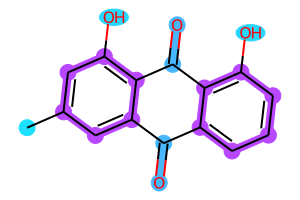

In [3]:
my_cmap = cm.get_cmap('cool')
patt = r'[C,H][0-9]{2}[0,-1,1]'
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=100)

smiles = input("Input SMILES:")
mol = Chem.MolFromSmiles(smiles)

a,b,c,d = mol2frag(mol, returnidx=True)
atommap,bondmap = {}, {}
for s,i in zip(a+b, c+d):
    if re.match(patt, s):
        m = Chem.MolFromSmiles(s[0])
    else:
        m = Chem.MolFromSmiles(s)
    mw = Descriptors.HeavyAtomMolWt(m)
    atommap.update({x:my_cmap(my_norm(mw))[:3] for x in i})

for b in mol.GetBonds():
    if atommap[b.GetBeginAtomIdx()] == atommap[b.GetEndAtomIdx()]:
        bondmap[b.GetIdx()]=atommap[b.GetBeginAtomIdx()]

highlights = {
    "highlightAtoms": list(atommap.keys()),
    "highlightAtomColors": atommap,
    "highlightBonds": list(bondmap.keys()),
    "highlightBondColors": bondmap,
}

prettymol(smiles, highlights=highlights,path='sample_mol.png')